# Microbusiness Density Forecasting

#### The goal of this project is to predict monthly microbusiness density in a given area. The model trained on U.S. county-level data. This will help policymakers gain visibility into microbusinesses, a growing trend of very small entities. Additional information will enable new policies and programs to improve the success and impact of these smallest of businesses.

### Data Loading

In [1]:
#Import the required libraries

import pandas as pd
import numpy as np
import random
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn import preprocessing

#Import the required libraries
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
#load the dataset
org_data = pd.read_csv("Data/labelled_data.csv")
additional_data = pd.read_csv("Data/additional_data.csv")

#Checking if there are any duplicate records
df1_rows = org_data['row_id']
df2_rows = additional_data['row_id']

print("Number of duplicate records in origninal and additional data : ", len(np.intersect1d(np.array(df1_rows),np.array(df2_rows))))

#Concatenating
frames = [org_data,additional_data]
data = pd.concat(frames,axis=0,join="outer",ignore_index=True,verify_integrity=True)
data['train'] = 1

#Load the unlabelled data also
unlabelled = pd.read_csv('Data/unlabelled_data.csv')
unlabelled['train'] = 0

#Checking duplicate records in unlabelled and data
df1_rows = data['row_id']
df2_rows = unlabelled['row_id']
print("Number of duplicate records in unlabelled and labelled : ", len(np.intersect1d(np.array(df1_rows),np.array(df2_rows))))

#Droping records that are duplicate
duplicates = list(np.intersect1d(np.array(df1_rows),np.array(df2_rows)))
unlabelled = unlabelled.loc[~unlabelled['row_id'].isin(duplicates)]


#Concatenating unique records
frames = [data,unlabelled]
data = pd.concat(frames,ignore_index=True,axis=0,join="outer",verify_integrity=False)

data.sort_values(['cfips','first_day_of_month'],inplace=True)
print("Shape of final data:",data.shape)

#Convert 'first_day_of_month' to datetime field
data['first_day_of_month'] = pd.to_datetime(data['first_day_of_month'])

# Create year field from the coloumn 'first_day_of_month'
data['year'] =  data['first_day_of_month'].dt.year
data['month'] = data['first_day_of_month'].dt.month
data.head(2)

#Drop row_id as it is no longer required
data.drop(columns=['row_id'],inplace=True)

Number of duplicate records in origninal and additional data :  0
Number of duplicate records in unlabelled and labelled :  6270
Shape of final data: (147345, 8)


In [3]:
#Load the census data
census = pd.read_csv("Data/census_data.csv")

In [4]:
census.head(2)

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0


* **pct_bb_[year]** - The percentage of households in the county with access to broadband of any type. Derived from ACS table B28002: PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD.
cfips - The CFIPS code.
* **pct_college_[year]** - The percent of the population in the county over age 25 with a 4-year college degree. Derived from ACS table S1501: EDUCATIONAL ATTAINMENT.
* **pct_foreign_born_[year]** - The percent of the population in the county born outside of the United States. Derived from ACS table DP02: SELECTED SOCIAL CHARACTERISTICS IN THE UNITED STATES.
* **pct_it_workers_[year]** - The percent of the workforce in the county employed in information related industries. Derived from ACS table S2405: INDUSTRY BY OCCUPATION FOR THE CIVILIAN EMPLOYED POPULATION 16 YEARS AND OVER.
* **median_hh_inc_[year]** - The median household income in the county. Derived from ACS table S1901: INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS).

It can be observed that the census data have many useful information. It would be very helpful to utilize these information in modelling

### Data Visualization

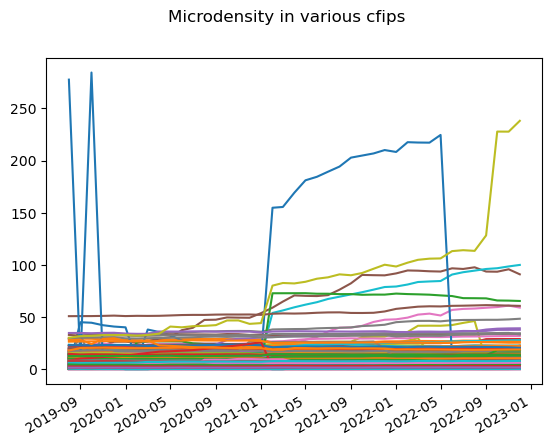

In [5]:
import matplotlib.pyplot as plt
unique_cfips = data['cfips'].unique()
fig, ax = plt.subplots()
for each in unique_cfips:
    a = data.loc[(data['cfips'] == each)]
    a = a[['first_day_of_month','microbusiness_density']]


    ax.plot(a['first_day_of_month'],a['microbusiness_density'])
fig.autofmt_xdate()
#ax.legend(['cfips - 1001'])
fig.suptitle('Microdensity in various cfips')
plt.show()

Few of the values shows abormal values in micro-business density

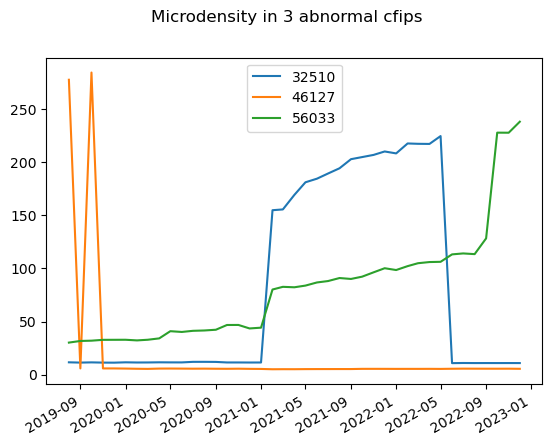

In [6]:
data[data['microbusiness_density'] > 150]

unusual_cfips = [32510,46127,56033]
fig, ax = plt.subplots()
for each in unusual_cfips:
    a = data.loc[(data['cfips'] == each)]
    a = a[['first_day_of_month','microbusiness_density']]


    ax.plot(a['first_day_of_month'],a['microbusiness_density'])
fig.autofmt_xdate()
ax.legend(unusual_cfips)
fig.suptitle('Microdensity in 3 abnormal cfips')
plt.show()

In [7]:
data.head()

,cfips,county,state,first_day_of_month,microbusiness_density,active,train,year,month
0,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,1,2019,8
1,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,1,2019,9
2,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,1,2019,10
3,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,1,2019,11
4,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,1,2019,12


### Data Manipulation

We need to handle the abnormal values in microdensity for the 2 cfips

For cfips 32510, a pattern can be observed in the data. The abnormal values can be made similair to other values by abing 1000 and then dividing by 100.

For cfips 46127, only two records have values in 200+ range and remaining all are between 5 and 6. Thus those two records are randomly assigned a number between 5 and 6.

In [8]:
density = np.array(data[data['cfips'] == 32510]['microbusiness_density'])
print('Micro-business density values for cfips 32510\n',density)

Micro-business density values for cfips 32510
 [ 11.617217  11.3572    11.563821  11.352556  11.296838  11.617307
  11.450717  11.485423  11.628876  11.55715   11.536325  12.054605
  12.070801  11.994447  11.485423  11.487737  11.432207  11.459338
 154.77109  155.50581  169.16472  181.05341  184.43082  189.30293
 194.23015  202.78964  204.76649  206.80765  210.0473   208.22719
 217.58711  217.25502  217.1413   224.53825   10.847511  10.981712
  10.91575   10.93622   10.920299  10.931671  10.911201        nan
        nan        nan        nan        nan        nan]


In [9]:
new_density = []
for each in density:
    if(each > 13):
        each += 1000
        each = round(each/100,7)
    new_density.append(each)
data.loc[data['cfips']==32510, 'microbusiness_density'] = new_density
print('New micro-business density values for cfips 32510\n',np.array(new_density))

New micro-business density values for cfips 32510
 [11.617217  11.3572    11.563821  11.352556  11.296838  11.617307
 11.450717  11.485423  11.628876  11.55715   11.536325  12.054605
 12.070801  11.994447  11.485423  11.487737  11.432207  11.459338
 11.5477109 11.5550581 11.6916472 11.8105341 11.8443082 11.8930293
 11.9423015 12.0278964 12.0476649 12.0680765 12.100473  12.0822719
 12.1758711 12.1725502 12.171413  12.2453825 10.847511  10.981712
 10.91575   10.93622   10.920299  10.931671  10.911201         nan
        nan        nan        nan        nan        nan]


In [10]:
density = np.array(data[data['cfips'] == 46127]['microbusiness_density'])
print('Micro-business density values for cfips 46127\n',density)
new_density = []
for each in density:
    if(each > 6):
        each = (np.random.random(1)+5)[0]
    new_density.append(each)
data.loc[data['cfips']==32510, 'microbusiness_density'] = new_density
print('New micro-business density values for cfips 46127\n',np.array(new_density))

Micro-business density values for cfips 46127
 [277.53598     5.8802629 284.34003     5.8713803   5.8624978   5.7331481
   5.5420432   5.4378042   5.7244616   5.7592077   5.6984015   5.6202226
   5.6636553   5.5681028   5.5159831   5.611536    5.4638638   5.384285
   5.0923142   5.1524258   5.135251    5.2211251   5.2554746   5.2640619
   5.2812366   5.2812366   5.4701591   5.4787464   5.4701591   5.4350576
   5.4519367   5.4434972   5.4772553   5.4181786   5.5616508   5.6629252
   5.6291671   5.6038485   5.5954089   5.6207275   5.5110135         nan
         nan         nan         nan         nan         nan]
New micro-business density values for cfips 46127
 [5.89188792 5.8802629  5.50921803 5.8713803  5.8624978  5.7331481
 5.5420432  5.4378042  5.7244616  5.7592077  5.6984015  5.6202226
 5.6636553  5.5681028  5.5159831  5.611536   5.4638638  5.384285
 5.0923142  5.1524258  5.135251   5.2211251  5.2554746  5.2640619
 5.2812366  5.2812366  5.4701591  5.4787464  5.4701591  5.4350576
 

In [11]:
#initialize new coloumns with Null values

data['pct_broadband']= np.nan
data['pct_college']= np.nan
data['pct_foreign_born']= np.nan
data['pct_IT_workers']= np.nan
data['median_income'] = np.nan

In [12]:
print('The data is from',data['year'].min(),'to',data['year'].max())
print("But the census data is not available for 2023, resulting in many Null values.")
print("To avoid this, 2 year is shifted while preparing the data.")

for index, row in data.iterrows():
    if(row['year'] == 2019):
        data.loc[index,'pct_broadband'] = census['pct_bb_2017'].loc[census['cfips'] == row['cfips']].item()
        data.loc[index,'pct_college'] = census['pct_college_2017'].loc[census['cfips'] == row['cfips']].item()
        data.loc[index,'pct_foreign_born'] = census['pct_foreign_born_2017'].loc[census['cfips'] == row['cfips']].item()
        data.loc[index,'pct_IT_workers'] = census['pct_it_workers_2017'].loc[census['cfips'] == row['cfips']].item()
        data.loc[index,'median_income'] = census['median_hh_inc_2017'].loc[census['cfips'] == row['cfips']].item()
    if(row['year'] == 2020):
        data.loc[index,'pct_broadband'] = census['pct_bb_2018'].loc[census['cfips'] == row['cfips']].item()
        data.loc[index,'pct_college'] = census['pct_college_2018'].loc[census['cfips'] == row['cfips']].item()
        data.loc[index,'pct_foreign_born'] = census['pct_foreign_born_2018'].loc[census['cfips'] == row['cfips']].item()
        data.loc[index,'pct_IT_workers'] = census['pct_it_workers_2018'].loc[census['cfips'] == row['cfips']].item()
        data.loc[index,'median_income'] = census['median_hh_inc_2018'].loc[census['cfips'] == row['cfips']].item()
    if(row['year'] == 2021):
        data.loc[index,'pct_broadband'] = census['pct_bb_2019'].loc[census['cfips'] == row['cfips']].item()
        data.loc[index,'pct_college'] = census['pct_college_2019'].loc[census['cfips'] == row['cfips']].item()
        data.loc[index,'pct_foreign_born'] = census['pct_foreign_born_2019'].loc[census['cfips'] == row['cfips']].item()
        data.loc[index,'pct_IT_workers'] = census['pct_it_workers_2019'].loc[census['cfips'] == row['cfips']].item()
        data.loc[index,'median_income'] = census['median_hh_inc_2019'].loc[census['cfips'] == row['cfips']].item()
    if(row['year'] == 2022):
        data.loc[index,'pct_broadband'] = census['pct_bb_2020'].loc[census['cfips'] == row['cfips']].item()
        data.loc[index,'pct_college'] = census['pct_college_2020'].loc[census['cfips'] == row['cfips']].item()
        data.loc[index,'pct_foreign_born'] = census['pct_foreign_born_2020'].loc[census['cfips'] == row['cfips']].item()
        data.loc[index,'pct_IT_workers'] = census['pct_it_workers_2020'].loc[census['cfips'] == row['cfips']].item()
        data.loc[index,'median_income'] = census['median_hh_inc_2020'].loc[census['cfips'] == row['cfips']].item()       
    if(row['year'] == 2023):
        data.loc[index,'pct_broadband'] = census['pct_bb_2021'].loc[census['cfips'] == row['cfips']].item()
        data.loc[index,'pct_college'] = census['pct_college_2021'].loc[census['cfips'] == row['cfips']].item()
        data.loc[index,'pct_foreign_born'] = census['pct_foreign_born_2021'].loc[census['cfips'] == row['cfips']].item()
        data.loc[index,'pct_IT_workers'] = census['pct_it_workers_2021'].loc[census['cfips'] == row['cfips']].item()
        data.loc[index,'median_income'] = census['median_hh_inc_2021'].loc[census['cfips'] == row['cfips']].item()       


The data is from 2019 to 2023
But the census data is not available for 2023, resulting in many Null values.
To avoid this, 2 year is shifted while preparing the data.


### Feature Engineering

Since this is a time-series data, it will be more beneficial if a time-step feature is used in modelling. Thus, a time dummy feature is added

In [13]:
dp = DeterministicProcess(
    index=data.first_day_of_month.unique(),  # dates from the training data
    constant=False,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=False,           # drop terms if necessary to avoid collinearity
    
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()


X.reset_index(inplace=True,names='dates')
X.columns= ['first_day_of_month','time_step']
data = data.merge(X, left_on='first_day_of_month', right_on='first_day_of_month')

data.sort_values(['cfips','first_day_of_month'],inplace=True)
data.head(2)

,cfips,county,state,first_day_of_month,microbusiness_density,active,train,year,month,pct_broadband,pct_college,pct_foreign_born,pct_IT_workers,median_income,time_step
0,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,1,2019,8,76.6,14.5,2.1,1.3,55317.0,1.0
3135,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,1,2019,9,76.6,14.5,2.1,1.3,55317.0,2.0


In [14]:
#Create a dictionary of all dates that includes the first day of month from 2019 to 2024

# dates = pd.date_range('2019-01-01','2024-01-01',freq='1M')- pd.offsets.MonthBegin(1)
# date_dict = {}
# iter = 0.01
# for each in dates:
#     date_dict[each] = iter
#     iter += 0.01


#Create a new feature coloumn based on this mapping

# data['time_dummy'] = np.nan

# for index, record in data.iterrows():
#     data.loc[index,'time_dummy'] = date_dict[record['first_day_of_month']]



Create lag features. Since the main objective is to forecast next month micro-business density, lets create 5 lag features. This will help in modelling serial dependence.

In [15]:
data['lag_1'] = data.groupby(['cfips'])['microbusiness_density'].shift(1)
#data['lag_2'] = data.groupby(['cfips'])['microbusiness_density'].shift(2)
#data['lag_3'] = data.groupby(['cfips'])['microbusiness_density'].shift(3)
#data['lag_4'] = data.groupby(['cfips'])['microbusiness_density'].shift(4)
#data['lag_5'] = data.groupby(['cfips'])['microbusiness_density'].shift(5)
#data['lag_6'] = data.groupby(['cfips'])['microbusiness_density'].shift(6)

In [16]:
data.head()

,cfips,county,state,first_day_of_month,microbusiness_density,active,train,year,month,pct_broadband,pct_college,pct_foreign_born,pct_IT_workers,median_income,time_step,lag_1
0,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,1,2019,8,76.6,14.5,2.1,1.3,55317.0,1.0,NaN
3135,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,1,2019,9,76.6,14.5,2.1,1.3,55317.0,2.0,3.007682
6270,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,1,2019,10,76.6,14.5,2.1,1.3,55317.0,3.0,2.884870
9405,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,1,2019,11,76.6,14.5,2.1,1.3,55317.0,4.0,3.055843
12540,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,1,2019,12,76.6,14.5,2.1,1.3,55317.0,5.0,2.993233


### Data Cleaning

In [17]:
#To check for missing values
data.isna().sum()

cfips                        0
county                   18810
state                    18810
first_day_of_month           0
microbusiness_density    18810
active                   18810
train                        0
year                         0
month                        0
pct_broadband                0
pct_college                  0
pct_foreign_born             0
pct_IT_workers              12
median_income               30
time_step                    0
lag_1                    18810
dtype: int64

It is very likely to have missing information in the data.

It can be observed that median_income and it_workers field have missing values. These needs to be handled seperately. For the remaining fields, the missing values came from merging the unlabelled data. Since the county, state values are same for a particular cfips, those values can be used to fill the missing values in those fields.
However, the null values in microdensity and active are caused by merging unlablelled data. Nothing needs to be done for this as this will be removed before model training

In [18]:
#Handling null values in county and state
data['county'] = data.groupby('cfips')['county'].transform(lambda x: x.ffill())
data['state'] = data.groupby('cfips')['state'].transform(lambda x: x.ffill())

In [19]:
#To check for missing values
data.isna().sum()

cfips                        0
county                       0
state                        0
first_day_of_month           0
microbusiness_density    18810
active                   18810
train                        0
year                         0
month                        0
pct_broadband                0
pct_college                  0
pct_foreign_born             0
pct_IT_workers              12
median_income               30
time_step                    0
lag_1                    18810
dtype: int64

In [20]:
data[data['pct_IT_workers'].isna()]

,cfips,county,state,first_day_of_month,microbusiness_density,active,train,year,month,pct_broadband,pct_college,pct_foreign_born,pct_IT_workers,median_income,time_step,lag_1
17488,35039,Rio Arriba County,New Mexico,2020-01-01,2.467572,740.0,1,2020,1,52.1,12.5,3.7,NaN,NaN,6.0,2.452189
20623,35039,Rio Arriba County,New Mexico,2020-02-01,2.434226,730.0,1,2020,2,52.1,12.5,3.7,NaN,NaN,7.0,2.467572
23758,35039,Rio Arriba County,New Mexico,2020-03-01,2.460902,738.0,1,2020,3,52.1,12.5,3.7,NaN,NaN,8.0,2.434226
26893,35039,Rio Arriba County,New Mexico,2020-04-01,2.520924,756.0,1,2020,4,52.1,12.5,3.7,NaN,NaN,9.0,2.460902
30028,35039,Rio Arriba County,New Mexico,2020-05-01,2.530928,759.0,1,2020,5,52.1,12.5,3.7,NaN,NaN,10.0,2.520924
33163,35039,Rio Arriba County,New Mexico,2020-06-01,2.530928,759.0,1,2020,6,52.1,12.5,3.7,NaN,NaN,11.0,2.530928
36298,35039,Rio Arriba County,New Mexico,2020-07-01,2.554270,766.0,1,2020,7,52.1,12.5,3.7,NaN,NaN,12.0,2.530928
39433,35039,Rio Arriba County,New Mexico,2020-08-01,2.560939,768.0,1,2020,8,52.1,12.5,3.7,NaN,NaN,13.0,2.554270
42568,35039,Rio Arriba County,New Mexico,2020-09-01,2.567608,770.0,1,2020,9,52.1,12.5,3.7,NaN,NaN,14.0,2.560939
45703,35039,Rio Arriba County,New Mexico,2020-10-01,2.560939,768.0,1,2020,10,52.1,12.5,3.7,NaN,NaN,15.0,2.567608


It seems like there is no data for it_workers in 2020 for one particular 'cfips'
Removing this record is not feasible and the most viable option is to use previous years value


In [21]:
print('Percentage of IT workers for that specific cfips in 2017 is', census[census['cfips'] == 35039]['pct_it_workers_2017'].item())

data.loc[data['pct_IT_workers'].isna(),'pct_IT_workers']  = census[census['cfips'] == 35039]['pct_it_workers_2017'].item()
data[17488:17489]

Percentage of IT workers for that specific cfips in 2017 is 0.8


,cfips,county,state,first_day_of_month,microbusiness_density,active,train,year,month,pct_broadband,pct_college,pct_foreign_born,pct_IT_workers,median_income,time_step,lag_1
12912,12109,St. Johns County,Florida,2019-12-01,13.09924,23144.0,1,2019,12,85.2,27.3,6.9,1.4,73640.0,5.0,13.213571


In [22]:
data[data['median_income'].isna()]

,cfips,county,state,first_day_of_month,microbusiness_density,active,train,year,month,pct_broadband,pct_college,pct_foreign_born,pct_IT_workers,median_income,time_step,lag_1
17488,35039,Rio Arriba County,New Mexico,2020-01-01,2.467572,740.0,1,2020,1,52.1,12.5,3.7,0.8,NaN,6.0,2.452189
20623,35039,Rio Arriba County,New Mexico,2020-02-01,2.434226,730.0,1,2020,2,52.1,12.5,3.7,0.8,NaN,7.0,2.467572
23758,35039,Rio Arriba County,New Mexico,2020-03-01,2.460902,738.0,1,2020,3,52.1,12.5,3.7,0.8,NaN,8.0,2.434226
26893,35039,Rio Arriba County,New Mexico,2020-04-01,2.520924,756.0,1,2020,4,52.1,12.5,3.7,0.8,NaN,9.0,2.460902
30028,35039,Rio Arriba County,New Mexico,2020-05-01,2.530928,759.0,1,2020,5,52.1,12.5,3.7,0.8,NaN,10.0,2.520924
33163,35039,Rio Arriba County,New Mexico,2020-06-01,2.530928,759.0,1,2020,6,52.1,12.5,3.7,0.8,NaN,11.0,2.530928
36298,35039,Rio Arriba County,New Mexico,2020-07-01,2.554270,766.0,1,2020,7,52.1,12.5,3.7,0.8,NaN,12.0,2.530928
39433,35039,Rio Arriba County,New Mexico,2020-08-01,2.560939,768.0,1,2020,8,52.1,12.5,3.7,0.8,NaN,13.0,2.554270
42568,35039,Rio Arriba County,New Mexico,2020-09-01,2.567608,770.0,1,2020,9,52.1,12.5,3.7,0.8,NaN,14.0,2.560939
45703,35039,Rio Arriba County,New Mexico,2020-10-01,2.560939,768.0,1,2020,10,52.1,12.5,3.7,0.8,NaN,15.0,2.567608


It seems like the median income data for cfips 35039 (year 2020), 48243 (year 2022) and 48301 (year 2023) are missing. So lets check previous year values.



In [23]:
print('Median Income for cfips 35039 in 2017: ',census[census['cfips'] == 35039]['median_hh_inc_2017'].item())
print('Median Income for cfips 48243 in 2019: ',census[census['cfips'] == 48243]['median_hh_inc_2019'].item())
print('Median Income for cfips 48301 in 2020: ',census[census['cfips'] == 48301]['median_hh_inc_2020'].item())

data.loc[(data['year'] == 2020) & (data['cfips'] == 35039),'median_income']  = census[census['cfips'] == 35039]['median_hh_inc_2017'].item()
data.loc[(data['year'] == 2022) & (data['cfips'] == 48243),'median_income']  = census[census['cfips'] == 48243]['median_hh_inc_2019'].item()
data.loc[(data['year'] == 2023) & (data['cfips'] == 48301),'median_income']  = census[census['cfips'] == 48301]['median_hh_inc_2020'].item()
                          

Median Income for cfips 35039 in 2017:  33422
Median Income for cfips 48243 in 2019:  53088
Median Income for cfips 48301 in 2020:  44076.0


In [24]:
#To check for missing values
data.isna().sum()

cfips                        0
county                       0
state                        0
first_day_of_month           0
microbusiness_density    18810
active                   18810
train                        0
year                         0
month                        0
pct_broadband                0
pct_college                  0
pct_foreign_born             0
pct_IT_workers               0
median_income                0
time_step                    0
lag_1                    18810
dtype: int64

#### Normalization and Factorization
Many feature coloumns can be normalized. Here, median_income, cfips are normalised

County and State is factorised into numerical coloumns

In [25]:
c_codes, c_uniques = data['county'].factorize()
data['county'] = c_codes

s_codes, s_uniques = data['state'].factorize()
data['state'] = s_codes


data['median_income'] = MinMaxScaler().fit_transform(np.array(data['median_income']).reshape(-1,1))
#data['cfips'] = MinMaxScaler().fit_transform(np.array(data['cfips']).reshape(-1,1))

data.head(2)


,cfips,county,state,first_day_of_month,microbusiness_density,active,train,year,month,pct_broadband,pct_college,pct_foreign_born,pct_IT_workers,median_income,time_step,lag_1
0,1001,0,0,2019-08-01,3.007682,1249.0,1,2019,8,76.6,14.5,2.1,1.3,0.273477,1.0,NaN
3135,1001,0,0,2019-09-01,2.884870,1198.0,1,2019,9,76.6,14.5,2.1,1.3,0.273477,2.0,3.007682


In [26]:
data_lookup = data.copy()
data_backup = data.copy()

####  Correlation

In [27]:
#Find correlation between various features
data.drop(columns=['first_day_of_month'], inplace=True)
corr_matrix = data.corr().abs()
corr_matrix

,cfips,county,state,microbusiness_density,active,train,year,month,pct_broadband,pct_college,pct_foreign_born,pct_IT_workers,median_income,time_step,lag_1
cfips,1.000000e+00,6.080585e-01,9.994320e-01,0.013127,0.062637,1.488780e-14,5.839399e-12,8.469411e-15,0.035290,0.045025,0.018151,0.035664,0.063438,7.836846e-15,0.013127
county,6.080585e-01,1.000000e+00,6.075474e-01,0.015523,0.035089,9.203736e-15,3.423057e-12,5.039001e-15,0.030261,0.073303,0.057241,0.014663,0.073831,5.206420e-15,0.015523
state,9.994320e-01,6.075474e-01,1.000000e+00,0.012331,0.060517,1.490513e-14,5.928643e-12,8.673730e-15,0.033365,0.045059,0.015187,0.035041,0.063861,7.785963e-15,0.012331
microbusiness_density,1.312713e-02,1.552341e-02,1.233054e-02,1.000000,0.334885,NaN,1.718398e-02,6.684172e-03,0.386677,0.524397,0.295864,0.279462,0.413033,1.950504e-02,0.948890
active,6.263677e-02,3.508875e-02,6.051685e-02,0.334885,1.000000,NaN,4.452502e-03,1.182866e-03,0.203903,0.278373,0.431478,0.253441,0.244927,4.893031e-03,0.336954
train,1.488780e-14,9.203736e-15,1.490513e-14,NaN,NaN,1.000000e+00,6.229312e-01,3.278763e-01,0.201934,0.036192,0.000159,0.027456,0.122699,5.781342e-01,0.008020
year,5.839399e-12,3.423057e-12,5.928643e-12,0.017184,0.004453,6.229312e-01,1.000000e+00,3.602007e-01,0.351527,0.059015,0.002241,0.046105,0.165927,9.708063e-01,0.017603
month,8.469411e-15,5.039001e-15,8.673730e-15,0.006684,0.001183,3.278763e-01,3.602007e-01,1.000000e+00,0.122409,0.019767,0.000792,0.017026,0.063662,1.259213e-01,0.003955
pct_broadband,3.528953e-02,3.026137e-02,3.336544e-02,0.386677,0.203903,2.019343e-01,3.515272e-01,1.224091e-01,1.000000,0.643785,0.277377,0.268332,0.728018,3.423476e-01,0.385377
pct_college,4.502498e-02,7.330254e-02,4.505907e-02,0.524397,0.278373,3.619220e-02,5.901508e-02,1.976702e-02,0.643785,1.000000,0.328836,0.365890,0.708445,5.767539e-02,0.524606


In [28]:
#Select upper traingle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))

#Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print("These coloumns have high correlation :",to_drop)


These coloumns have high correlation : ['state', 'time_step']


time_step feature is highly correlated to year feature. So, year coloumn is dropped from the data. Similarly, state and cfips features are highly correlated. 

In [29]:
data.drop(columns=['state','year','active'],inplace=True)
#data.drop(columns=[='lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6'],inplace=True)

In [30]:
#Split the dataset into train and unlabelled
#The unlabelled data includes data to be forecasted

cols = np.delete(np.array(data.columns), np.where(np.array(data.columns) == 'train'))
unlabelled = data.loc[(data['train'] == 0),cols]
train = data.loc[(data['train'] == 1),cols]

train.dropna(inplace=True)

#train, test = train_test_split(data,test_size=0.2, shuffle=True)


y_train = train.pop('microbusiness_density')
X_train = train

# y_test = test.pop('microbusiness_density')
# X_test = test
# data.head()


In [31]:
# #Using MinMaxSclaer
# x = X_data.values
# min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0.1,0.99))
# X_scaled = min_max_scaler.fit_transform(x)
# X_scaled= pd.DataFrame(X_scaled)

# #Using Normalizer
# normalizer = preprocessing.Normalizer()
# X_normalised = normalizer.fit_transform(x)
# X_normalised = pd.DataFrame(X_normalised)

## Approach - RandomForest, XGBoost and DecisionTree

In [32]:
#Create model objects
rfmodel = RandomForestRegressor()

xgb_model = XGBRegressor(
        objective='reg:pseudohubererror',
        tree_method="hist",
        n_estimators=795,
        learning_rate=0.0075,
        max_leaves = 17,
        subsample=0.50,
        colsample_bytree=0.50,
        max_bin=4096,
        n_jobs=2,
        eval_metric='mae',)

dt_model = DecisionTreeRegressor()

models = [(rfmodel,'RandomForest'),(xgb_model,'XGBoost'),(dt_model,'DecisionTree')]
#RFmodel.fit(X_train_scaled,y_train)
#RFmodel.fit(X_train,y_train)
#xgb_model.fit(X_train,y_train)

In [33]:
for model, name in models:
    crossValidated = RepeatedKFold(n_splits=10,n_repeats=3,random_state=1)
    # evaluate the model
    #Use sklearn.metrics.get_scorer_names() to get valid options.
    scores = ross_val_score(model,X_train,y_train,scoring='neg_mean_squared_error',cv=crossValidated,n_jobs=-1)
    print(name,'- Mean Cross validated rmse score:',np.mean((-scores)**0.5))
    #print((-scores)**0.5)
    print(" ")

RandomForest - Mean Cross validated rmse score: 0.9708431323071504
 
XGBoost - Mean Cross validated rmse score: 1.1157988820781772
 
DecisionTree - Mean Cross validated rmse score: 1.1273112796083258
 


In [34]:
#From the above, the best performing model is Random Forest.
rfmodel.fit(X_train,y_train)


RandomForestRegressor()

#### Forecasting

To forecast the mico-business density, enter the cfips id.


In [68]:
data_lookup = data_backup.copy()

In [79]:
cfips = random.choice(data_lookup['cfips'].values)
data_lookup.loc[(data_lookup['cfips'] == cfips) & (data_lookup['first_day_of_month'] == '2023-04-01')]

,cfips,county,state,first_day_of_month,microbusiness_density,active,train,year,month,pct_broadband,pct_college,pct_foreign_born,pct_IT_workers,median_income,time_step,lag_1
139650,31119,44,27,2023-04-01,NaN,NaN,0,2023,4,83.4,16.9,6.7,0.5,0.273892,45.0,NaN


In [80]:
period = ['2023-01-01','2023-02-01','2023-03-01','2023-04-01','2023-05-01','2023-06-01']
forecast_range = [np.datetime64(pd.Timestamp('2022-12-01'))]
forecast_value = [data_lookup.loc[(data_lookup['cfips'] == cfips) & (data_lookup['first_day_of_month'] == '2022-12-01'),'microbusiness_density'].values[0]]
#period = ['2023-01-01','2023-02-01','2023-03-01','2023-04-01','2023-05-01','2023-06-01']
pd.set_option('mode.chained_assignment',None)
for i, date in enumerate(period):
    forecast = data_lookup.loc[(data_lookup['cfips'] == cfips) & (data_lookup['first_day_of_month'] == period[i])]
    forecast.drop(columns = ['active','microbusiness_density','first_day_of_month','state','train','year'],inplace=True)

    predicted = rfmodel.predict(forecast)
    print("The forecasted microbusiness density for cfips",cfips,"in",period[i],"is",round(predicted[0],6))
    forecast_value.append(predicted[0])
    forecast_range.append(np.datetime64(pd.Timestamp(period[i])))

    if(i<5):
        data_lookup.loc[(data_lookup['cfips'] == cfips) & (data_lookup['first_day_of_month'] == period[i+1]),'lag_1'] = predicted[0]
    

The forecasted microbusiness density for cfips 31119 in 2023-01-01 is 3.140224
The forecasted microbusiness density for cfips 31119 in 2023-02-01 is 3.14737
The forecasted microbusiness density for cfips 31119 in 2023-03-01 is 3.145651
The forecasted microbusiness density for cfips 31119 in 2023-04-01 is 3.135814
The forecasted microbusiness density for cfips 31119 in 2023-05-01 is 3.150739
The forecasted microbusiness density for cfips 31119 in 2023-06-01 is 3.158463


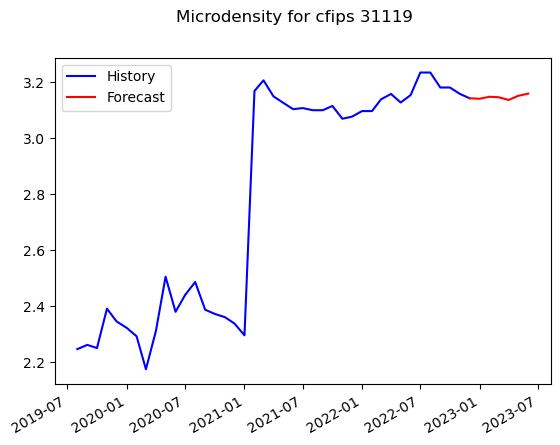

In [87]:
#Ploting the forecast
fig, ax = plt.subplots()
a = data_lookup.loc[(data_lookup['cfips'] == cfips) & (data_lookup['train']== 1)]
a = a[['first_day_of_month','microbusiness_density']]
xlabels = a['first_day_of_month'].values
ylabels = a['microbusiness_density'].values
ax.plot(xlabels,ylabels,c='b')


#xlabels = np.append(xlabels,np.datetime64(pd.Timestamp(date)))
#ylabels = np.append(ylabels,predicted[0])

ax.plot(forecast_range,forecast_value,c='r')
#ax.plot(np.array(a['first_day_of_month']),a['microbusiness_density'],c='r')
#ax.plot(a['first_day_of_month'][-2:],a['microbusiness_density'][-2:],c='b')
#ax.plot(predicted[0],c='b')
#ax.plot(a['first_day_of_month'],predicted*41)
fig.autofmt_xdate()
ax.legend(['History','Forecast'])
fig.suptitle('Microdensity for cfips ' + str(cfips))
plt.show()